In [4]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-Model"
FIGPREFIX = "Figure7"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
# All ref data
ref = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_annot_v2.bed"), sep="\t")
ref = pd.merge(ref, allstrs, on=["chrom","str.start"])
ref["str.start"] = ref["str.start"]+1
dnaseI = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])
dnaseI["str.start"] = dnaseI["str.start"]+1

# eSTR
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

Populating the interactive namespace from numpy and matplotlib


In [67]:
data = pd.merge(ref, causal, on=["chrom","str.start"])
data = pd.merge(data, dnaseI, on=["chrom","str.start"])
data["dnase"] = (data["dist.dnase"].apply(abs)<500).apply(int)

{'hg19_promoter_1kb': 158, 'all': 3475, '3utr': 123, '5utr': 63, 'intergenic': 1258, 'coding': 16, 'hg19_promoter_3kb': 452, 'introns': 2088, 'dnase': 528}


{'3utr': array(['A:40', 'AC:33', 'AAAC:6', 'AAAT:5', 'AT:5'], dtype=object),
 '5utr': array(['CCG:18', 'AC:14', 'A:12', 'AAAC:4', 'AAAT:1'], dtype=object),
 'all': array(['A:1338', 'AC:871', 'AAAT:226', 'AAAC:182', 'AT:107'], dtype=object),
 'coding': array(['AGC:4', 'AGG:3', 'CCG:2', 'ACC:1', 'ACCCCC:1'], dtype=object),
 'dnase': array(['AC:169', 'A:142', 'AAAC:21', 'AAAT:20', 'CCG:20'], dtype=object),
 'hg19_promoter_1kb': array(['AC:42', 'A:35', 'CCCCG:9', 'CCG:9', 'C:7'], dtype=object),
 'hg19_promoter_3kb': array(['A:143', 'AC:108', 'AAAC:23', 'AAAT:20', 'AT:15'], dtype=object),
 'intergenic': array(['A:473', 'AC:319', 'AAAT:80', 'AAAC:72', 'AT:44'], dtype=object),
 'introns': array(['A:834', 'AC:522', 'AAAT:143', 'AAAC:103', 'AT:58'], dtype=object)}

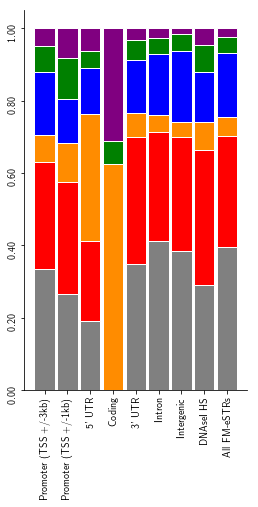

In [68]:
# Get period breakdown and top motifs for each category

annot_cols = ["hg19_promoter_3kb","hg19_promoter_1kb","5utr","coding","3utr","introns","intergenic","dnase","all"]
annot_labels = ["Promoter (TSS +/-3kb)", "Promoter (TSS +/-1kb)", "5' UTR", "Coding", "3' UTR", "Intron", "Intergenic","DNAseI HS","All FM-eSTRs"]
annot_totals = {}
annot_to_period = {}
annot_to_topmotifs = {}

for col in annot_cols:
    if col == "all":
        d = data
    else: d = data[data[col]>0]
    vals = []
    for p in range(1, 7):
        vals.append(d[d["period"]==p].shape[0]*1.0/d.shape[0])
    md = d.groupby("motif_x", as_index=False).agg({"str.start": len}).sort_values("str.start", ascending=False)
    annot_to_topmotifs[col] = md.apply(lambda x: "%s:%s"%(x["motif_x"], x["str.start"]), 1).values[0:5]
    annot_to_period[col] = vals
    annot_totals[col] = d.shape[0]



percolors = ["gray","red","darkorange","blue","green","purple"]

fig = plt.figure()
fig.set_size_inches((4, 7))
ax = fig.add_subplot(111)

xvals = range(len(annot_cols))
bottoms = [0]*len(annot_cols)
for period in range(1, 7):
    yvals = [annot_to_period[col][period-1] for col in annot_cols]
    ax.bar(xvals, yvals, bottom=bottoms, color=percolors[period-1], edgecolor="white", width=0.9)
    bottoms = [bottoms[i]+yvals[i] for i in range(len(bottoms))]
ax.set_xticks(xvals)
ax.set_xticklabels(annot_labels, rotation=90)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.savefig(os.path.join(RESULTSDIR, "%s_annotation_breakdown.pdf"%FIGPREFIX))
print(annot_totals)
annot_to_topmotifs

In [46]:
RESULTSDIR

'/storage/mgymrek/gtex-estrs-paper/results/eSTR-Model'